In [1]:
# Cell 1 - import the things you need
import logging
import sys
from functools import partial
import typing

import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy import stats

from hamilton import ad_hoc_utils, driver, base

logging.basicConfig(stream=sys.stdout)

In [2]:
# Cell 2 - import modules to create part of the DAG from
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1
# import the function modules you want to reload when they change.
# i.e. these should be your modules you write your functions in. As you change them,
# they will be reimported without you having to do anything.
# %aimport analysis_flow 

In [3]:
# Cell 3 - Define your new Hamilton functions & curate them into a TemporaryFunctionModule object.
# This enables you to add functions to your DAG without creating a proper module.
# This is ONLY INTENDED FOR QUICK DEVELOPMENT. For moving to production move these to an actual module.


# We'll take out all the private functions into their own separate module
def _moving_mean(a, n):
    """Computes the moving mean using numpy constructs."""
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


def _compute_indices(breakpoints: dict, aqi: np.ndarray, pol: str, con: float) -> float:
    """Computes break points for pollutants

    The compute_indices function first fetches the correct upper and lower bounds of AQI categories and breakpoint
    concentrations for the input concentration and pollutant with the help of arrays AQI and breakpoints.

    It is code copied straight from
    https://github.com/numpy/numpy-tutorials/blob/main/content/tutorial-air-quality-analysis.md


    :param breakpoints: dictionary of pollutant to break points.
    :param aqi: array of AQI break points.
    :param pol: pollutant
    :param con: concentration
    :return: index computed
    """
    bp = breakpoints[pol]

    if pol == "CO":
        inc = 0.1
    else:
        inc = 1

    if bp[0] <= con < bp[1]:
        Bl = bp[0]
        Bh = bp[1] - inc
        Ih = aqi[1] - inc
        Il = aqi[0]
    elif bp[1] <= con < bp[2]:
        Bl = bp[1]
        Bh = bp[2] - inc
        Ih = aqi[2] - inc
        Il = aqi[1]
    elif bp[2] <= con < bp[3]:
        Bl = bp[2]
        Bh = bp[3] - inc
        Ih = aqi[3] - inc
        Il = aqi[2]
    elif bp[3] <= con < bp[4]:
        Bl = bp[3]
        Bh = bp[4] - inc
        Ih = aqi[4] - inc
        Il = aqi[3]
    elif bp[4] <= con < bp[5]:
        Bl = bp[4]
        Bh = bp[5] - inc
        Ih = aqi[5] - inc
        Il = aqi[4]
    elif bp[5] <= con:
        Bl = bp[5]
        Bh = bp[5] + bp[4] - (2 * inc)
        Ih = aqi[6]
        Il = aqi[5]
    else:
        print(f"Concentration {con} out of range!")
        raise ValueError(f"Concentration {con} out of range!")

    return ((Ih - Il) / (Bh - Bl)) * (con - Bl) + Il


def _t_test(x, y):
    """Classic t-test"""
    diff = y - x
    var = np.var(diff, ddof=1)
    num = np.mean(diff)
    denom = np.sqrt(var / len(x))
    return np.divide(num, denom)


# Place the functions into a temporary module -- the idea is that this should house a curated set of functions.
# Don't be afraid to make multiple of them -- however we'd advise you to not use this method for production.
# Also note, that using a temporary function module does not work for scaling onto Ray, Dask, or Pandas on Spark.
private_helpers = ad_hoc_utils.create_temporary_module(
    _moving_mean,
    _compute_indices,
    module_name="private_helpers",
)

In [4]:
# Cell 4 - Define your new Hamilton functions & curate them into a TemporaryFunctionModule object.
# This enables you to add functions to your DAG without creating a proper module.
# This is ONLY INTENDED FOR QUICK DEVELOPMENT. For moving to production move these to an actual module.

# Here I am separating out the function to calculate the AQI index array into a separate module


def pollutant_data(input_file_name: str = "air-quality-data.csv") -> np.ndarray:
    """Returns the raw pollutant data."""
    return np.loadtxt(
        input_file_name, dtype=float, delimiter=",", skiprows=1, usecols=range(1, 8)
    )


def pollutants_A(pollutant_data: np.ndarray) -> np.ndarray:
    """Pollutant A"""
    return pollutant_data[:, 0:5]


def pollutants_B(pollutant_data: np.ndarray) -> np.ndarray:
    """Pollutant B"""
    return pollutant_data[:, 5:]


def pollutants_A_24hr_avg(pollutants_A: np.ndarray) -> np.ndarray:
    """24 hour move average of pollutant A."""
    return _moving_mean(pollutants_A, 24)


def pollutants_B_8hr_avg(
    pollutants_B: np.ndarray, pollutants_A_24hr_avg: np.ndarray
) -> np.ndarray:
    """8 hour move average of pollutant B.
    To make sure both the sets are of the same length, we will truncate the pollutants_B_8hr_avg according to
    the length of pollutants_A_24hr_avg. This will also ensure we have concentrations for all the pollutants
    over the same period of time.
    """
    return _moving_mean(pollutants_B, 8)[-(pollutants_A_24hr_avg.shape[0]) :]


def pollutants(
    pollutants_A_24hr_avg: np.ndarray, pollutants_B_8hr_avg: np.ndarray
) -> np.ndarray:
    """Concatenates Pollutants A and Pollutants B.

    Now, we can join both sets with np.concatenate to form a single data set of all the averaged concentrations.
    Note that we have to join our arrays column-wise so we pass the axis=1 parameter.
    """
    return np.concatenate((pollutants_A_24hr_avg, pollutants_B_8hr_avg), axis=1)


def AQI() -> np.ndarray:
    """AQI ranges.
    See https://github.com/numpy/numpy-tutorials/blob/main/content/tutorial-air-quality-analysis.md#calculating-the-air-quality-index
    """
    return np.array([0, 51, 101, 201, 301, 401, 501])


def breakpoints() -> dict:
    """AQI breakpoints for pollutants.
    See https://github.com/numpy/numpy-tutorials/blob/main/content/tutorial-air-quality-analysis.md#calculating-the-air-quality-index
    """
    return {
        "PM2.5": np.array([0, 31, 61, 91, 121, 251]),
        "PM10": np.array([0, 51, 101, 251, 351, 431]),
        "NO2": np.array([0, 41, 81, 181, 281, 401]),
        "NH3": np.array([0, 201, 401, 801, 1201, 1801]),
        "SO2": np.array([0, 41, 81, 381, 801, 1601]),
        "CO": np.array([0, 1.1, 2.1, 10.1, 17.1, 35]),
        "O3": np.array([0, 51, 101, 169, 209, 749]),
    }


def sub_indices(
    pollutants: np.ndarray, breakpoints: dict, AQI: np.ndarray
) -> np.ndarray:
    """Return sub indicies.

    The subindices for each pollutant are calculated according to the linear relationship between the AQI and standard
    breakpoint ranges with the formula as above:

        $$ Ip = \dfrac{\text{IHi – ILo}}{\text{BPHi – BPLo}}\cdot{\text{Cp – BPLo}} + \text{ILo} $$

    By calling our vectorized function vcompute_indices for each pollutant, we get the sub-indices.
    To get back an array with the original shape, we use np.stack.
    """
    vcompute_indices = np.vectorize(partial(_compute_indices, breakpoints, AQI))
    return np.stack(
        (
            vcompute_indices("PM2.5", pollutants[..., 0]),
            vcompute_indices("PM10", pollutants[..., 1]),
            vcompute_indices("NO2", pollutants[..., 2]),
            vcompute_indices("NH3", pollutants[..., 3]),
            vcompute_indices("SO2", pollutants[..., 4]),
            vcompute_indices("CO", pollutants[..., 5]),
            vcompute_indices("O3", pollutants[..., 6]),
        ),
        axis=1,
    )


def aqi_array(sub_indices: np.ndarray) -> np.ndarray:
    """Using np.max, we find out the maximum sub-index for each period, which is our Air Quality Index!"""
    return np.max(sub_indices, axis=1)


# We'll place the hourly calculations to their own module
hourly_calculations = ad_hoc_utils.create_temporary_module(
    pollutant_data,
    pollutants_A,
    pollutants_B,
    pollutants_A_24hr_avg,
    pollutants_B_8hr_avg,
    pollutants,
    AQI,
    breakpoints,
    sub_indices,
    aqi_array,
    module_name="hourly_calculations",
)

In [5]:
# Cell 5 - Define your new Hamilton functions & curate them into a TemporaryFunctionModule object.
# This enables you to add functions to your DAG without creating a proper module.
# This is ONLY INTENDED FOR QUICK DEVELOPMENT. For moving to production move these to an actual module.

# Finally we'll do the t_test and p_value calculations in thier own module


def datetime_index(
    pollutants_A_24hr_avg: np.ndarray, input_file_name: str
) -> np.ndarray:
    """We will now import the datetime column from our original dataset into a datetime64 dtype array.
    We will use this array to index the AQI array and obtain subsets of the dataset."""
    return np.loadtxt(
        input_file_name, dtype="M8[h]", delimiter=",", skiprows=1, usecols=(0,)
    )[-(pollutants_A_24hr_avg.shape[0]) :]


def after_lock(
    aqi_array: np.ndarray, datetime_index: np.ndarray, after_lock_date: str
) -> np.ndarray:
    """Grab period after lock down."""
    return aqi_array[np.where(datetime_index >= np.datetime64(after_lock_date))]


def before_lock(
    aqi_array: np.ndarray,
    datetime_index: np.ndarray,
    after_lock: np.ndarray,
    before_lock_date: str,
) -> np.ndarray:
    """Grab period before lock down."""
    return aqi_array[np.where(datetime_index <= np.datetime64(before_lock_date))][
        -(after_lock.shape[0]) :
    ]


def rng() -> typing.Any:
    """Returns random generator (not sure what type it is)."""
    return default_rng()


def before_sample(rng: typing.Any, before_lock: np.ndarray) -> np.ndarray:
    """Returns sample before lock down."""
    return rng.choice(before_lock, size=30, replace=False)


def after_sample(rng: typing.Any, after_lock: np.ndarray) -> np.ndarray:
    """Returns sample after lock down."""
    return rng.choice(after_lock, size=30, replace=False)


def t_value(before_sample: np.ndarray, after_sample: np.ndarray) -> np.ndarray:
    """T-value computed from t-test between before and after sample."""
    return _t_test(before_sample, after_sample)


def dof(before_sample: np.ndarray) -> int:
    """Degrees of freedom based on before sample."""
    return len(before_sample) - 1


def p_value(t_value: np.ndarray, dof: int) -> float:
    """P-value computed from t-value and degrees of freedom."""
    return stats.distributions.t.cdf(t_value, dof)


# We'll place the hourly calculations to their own module
statistic_calculations = ad_hoc_utils.create_temporary_module(
    datetime_index,
    after_lock,
    before_lock,
    rng,
    before_sample,
    after_sample,
    t_value,
    dof,
    p_value,
    module_name="statistic_calculations",
)

In [6]:
adapter = base.SimplePythonGraphAdapter(base.DictResult())
# adapter = base.SimplePythonGraphAdapter(base.NumpyMatrixResult())  # could also get a numpy matrix back.
dr = driver.Driver(
    {
        "input_file_name": "air-quality-data.csv",
        "after_lock_date": "2020-03-24T00",
        "before_lock_date": "2020-03-21T00",
    },
    private_helpers,
    hourly_calculations,
    statistic_calculations,
    adapter=adapter,
)

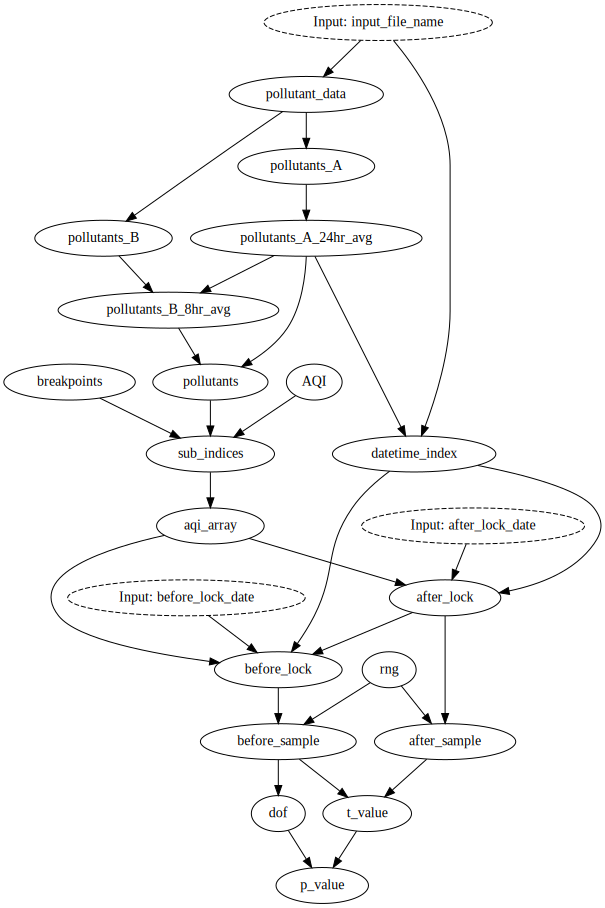

In [7]:
# Visualize execution
# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work

# visualize all possible functions
dr.display_all_functions(None)  # we pass None to not save the image to file.

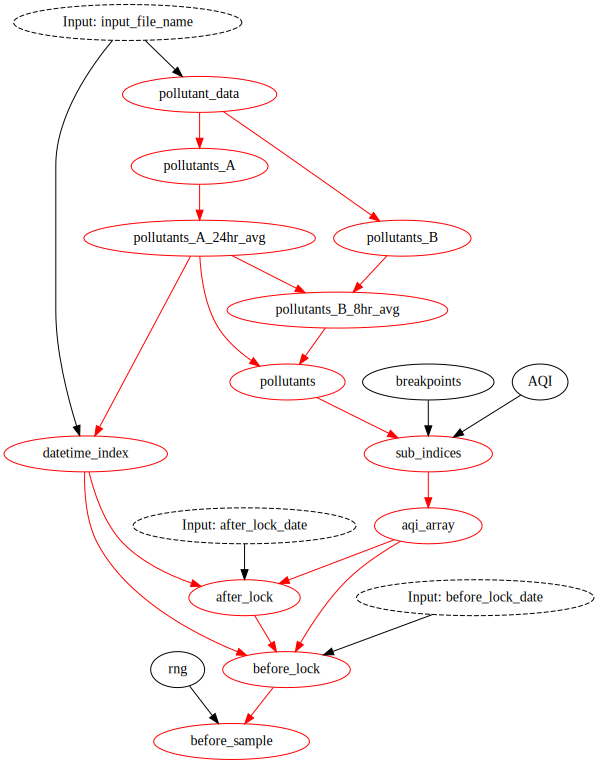

In [8]:
# visualize the path of execution between two functions
dr.visualize_path_between("pollutant_data", "before_sample", None, strict_path_visualization=False)

In [9]:
# let's create the dataframe!
output = ["t_value", "p_value", "before_sample", "after_sample"]
result = dr.execute(output)
print(result)
print(f"The t value is {result['t_value']} and the p value is {result['p_value']}.")

{'t_value': -6.92605129420375, 'p_value': 6.510618224099641e-08, 'before_sample': array([148.19221477, 224.14125   , 251.4800431 , 277.18448276,
       113.50788591, 382.00988372, 292.37017241, 345.20177326,
       122.39047819, 129.71426724, 306.24258721, 300.62017241,
       351.83406977, 159.97043103, 169.49918103, 110.54674497,
       310.16069767, 160.45831897,  85.11958333, 187.91232759,
       327.33093023, 422.72934174, 301.5162931 , 454.35784314,
       345.8102907 , 124.16201342, 138.25511745, 380.08040698,
       303.34677326, 297.69      ]), 'after_sample': array([ 66.3875    , 101.8183557 , 131.58895134, 128.37975671,
        86.93125   ,  77.20666667, 113.34842282, 142.72285235,
        68.9075    ,  91.66208333, 135.32858221, 120.18706376,
       168.47364933, 133.51884228,  63.06625   ,  85.895     ,
        89.74458333, 135.27099832, 114.71687081, 124.75307886,
       139.74205537,  92.00875   , 125.33556208,  68.54041667,
       218.11306034, 140.97983221, 140.3832298

In [10]:
sample_matrix = base.NumpyMatrixResult().build_result(
        before_sample=result["before_sample"], after_sample=result["after_sample"]
    )
print(sample_matrix)

[[148.19221477  66.3875    ]
 [224.14125    101.8183557 ]
 [251.4800431  131.58895134]
 [277.18448276 128.37975671]
 [113.50788591  86.93125   ]
 [382.00988372  77.20666667]
 [292.37017241 113.34842282]
 [345.20177326 142.72285235]
 [122.39047819  68.9075    ]
 [129.71426724  91.66208333]
 [306.24258721 135.32858221]
 [300.62017241 120.18706376]
 [351.83406977 168.47364933]
 [159.97043103 133.51884228]
 [169.49918103  63.06625   ]
 [110.54674497  85.895     ]
 [310.16069767  89.74458333]
 [160.45831897 135.27099832]
 [ 85.11958333 114.71687081]
 [187.91232759 124.75307886]
 [327.33093023 139.74205537]
 [422.72934174  92.00875   ]
 [301.5162931  125.33556208]
 [454.35784314  68.54041667]
 [345.8102907  218.11306034]
 [124.16201342 140.97983221]
 [138.25511745 140.38322987]
 [380.08040698  31.20277778]
 [303.34677326  86.66666667]
 [297.69       141.36935403]]
